In [55]:
import ibapi
from ibapi.client import EClient
from ibapi.wrapper import EWrapper
from ibapi.contract import Contract
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
import tensorflow as tf
from tensorflow import keras
import pandas
import datetime
from datetime import date
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('C:\\src\\stockPredictor\\SpyHist.csv')
df['Difference'] = df['Difference'].astype(float)
df['Open'] = df['Open'].astype(float)
df['Close'] = df['Close'].astype(float)
new_day_data = pd.read_csv('C:\\src\\stockPredictor\\dailySpy.csv')
new_day_data['Difference'] = new_day_data['Difference'].astype(float)
new_day_data['Open'] = new_day_data['Open'].astype(float)
new_day_data['Close'] = new_day_data['Close'].astype(float)

scaler = MinMaxScaler()
df[['scalars']] = scaler.fit_transform(df[['Difference']])
new_day_data[['scalars']] = scaler.transform(new_day_data[['Difference']])

df=df.set_index('DateTime')
new_day_data=new_day_data.set_index('DateTime')

maxSteps = len(df.time.unique())

In [62]:
count = 0

for i in range(1, maxSteps - 1):
    # Create sequences of past and future data
    X = []
    y = []

    for currentDate in df.date.unique():
        past_sequence = df.loc[df['date']==currentDate][0:i]['scalars']
        future_sequence = df[df['date']==currentDate][i:maxSteps]['scalars']
        X.append(past_sequence)
        y.append(future_sequence)

    X = np.array(X)
    y = np.array(y)

    # Reshape the data for LSTM (batch_size, timesteps, input_dim)
    X = X.reshape(-1, i, 1)
    y = y.reshape(-1, maxSteps - i, 1)
    
    # Define the model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(i, 1)))
    model.add(Dense(maxSteps - i))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model (you can adjust the number of epochs and batch size)
    model.fit(X, y, epochs=20, batch_size=32)
    
    model.save('model_'+str(df.time.unique()[i]).replace(':','_')+'.keras')


Epoch 1/20
3/3 [==============================] - 1s 2ms/step - loss: 0.2543
Epoch 2/20
3/3 [==============================] - 0s 997us/step - loss: 0.2502
Epoch 3/20
3/3 [==============================] - 0s 2ms/step - loss: 0.2461
Epoch 4/20
3/3 [==============================] - 0s 1ms/step - loss: 0.2420
Epoch 5/20
3/3 [==============================] - 0s 1ms/step - loss: 0.2378
Epoch 6/20
3/3 [==============================] - 0s 1ms/step - loss: 0.2335
Epoch 7/20
3/3 [==============================] - 0s 2ms/step - loss: 0.2291
Epoch 8/20
3/3 [==============================] - 0s 1ms/step - loss: 0.2246
Epoch 9/20
3/3 [==============================] - 0s 2ms/step - loss: 0.2200
Epoch 10/20
3/3 [==============================] - 0s 1ms/step - loss: 0.2153
Epoch 11/20
3/3 [==============================] - 0s 1ms/step - loss: 0.2104
Epoch 12/20
3/3 [==============================] - 0s 2ms/step - loss: 0.2054
Epoch 13/20
3/3 [==============================] - 0s 1ms/step - loss: 

In [42]:
new_model = tf.keras.models.load_model('model_12_50_00.keras')

In [63]:
# Generate predictions for a given input sequence (39 past ticks)
testdata=new_day_data[0:30]
X = np.array(new_day_data['scalars'])
input_sequence = X.reshape(1, len(new_day_data), 1)
predicted_sequence = scaler.inverse_transform(new_model.predict(input_sequence))

1/1 [==============================] - 0s 13ms/step


In [64]:
dfTotal = pandas.DataFrame(columns=['Total','Time'])
Total = 0
count = 0

for currentTime in df.time.unique():
    if(new_day_data.loc[new_day_data['time']==currentTime].empty is False):
        Total = Total + new_day_data.loc[new_day_data['time']==currentTime]['Difference'].values[0]
    else:
        Total = Total + predicted_sequence[0][count]
        count = count + 1
    timeObj = datetime.datetime.strptime(currentTime, '%H:%M:%S').time()
    dfTotal.loc[len(dfTotal.index)] = [Total,timeObj] 

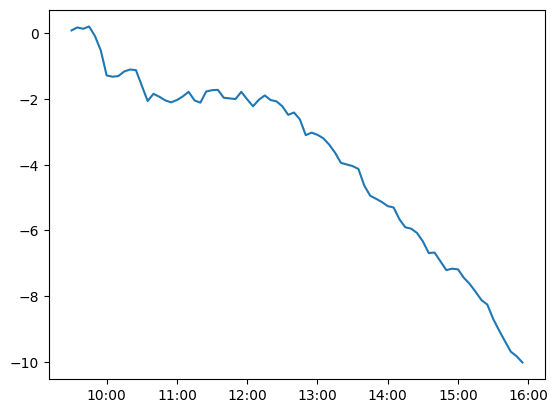

In [65]:
datetimes = [datetime.datetime.combine(datetime.date.today(), t) for t in dfTotal["Time"]]
xformatter = mdates.DateFormatter('%H:%M')
plt.plot(datetimes, dfTotal["Total"], label = "curve 1")
plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
plt.show()

In [47]:
predicted_sequence

array([[-0.479069  ,  0.07589996, -0.06513017, -0.10628682, -0.19203831,
        -0.24504973, -0.31100324, -0.04881817, -0.04979314, -0.08900674,
        -0.5054974 , -0.30795583, -0.09231686, -0.09972042, -0.12422764,
        -0.04114566, -0.36071855, -0.24321969, -0.04189039, -0.13022387,
        -0.25660646, -0.354938  ,  0.0140782 , -0.26565173, -0.26813477,
         0.0437841 , -0.02069688, -0.25729683, -0.18868533, -0.23657005,
        -0.25250438, -0.13678536, -0.43409902, -0.34974468, -0.32608435,
        -0.32237512, -0.14110829, -0.19051045]], dtype=float32)

In [35]:

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
display(dfTotal)

# Resets the options
pd.reset_option('all')

C:\Users\tmcna\AppData\Local\Temp\ipykernel_14156\3039856532.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


Total      Time
0   0.360000  09:30:00
1   0.340000  09:35:00
2  -0.190000  09:40:00
3  -0.320000  09:45:00
4  -0.090000  09:50:00
5  -0.040000  09:55:00
6  -0.020000  10:00:00
7   0.270000  10:05:00
8   0.250000  10:10:00
9   0.430000  10:15:00
10  0.450000  10:20:00
11  0.280000  10:25:00
12  0.440000  10:30:00
13  0.160000  10:35:00
14  0.410000  10:40:00
15  0.420000  10:45:00
16  0.420000  10:50:00
17  0.610000  10:55:00
18  0.600000  11:00:00
19  0.410000  11:05:00
20  0.390000  11:10:00
21  0.760000  11:15:00
22  0.900000  11:20:00
23  1.010000  11:25:00
24  1.300000  11:30:00
25  1.260000  11:35:00
26  1.590000  11:40:00
27  1.510000  11:45:00
28  1.660000  11:50:00
29  1.600000  11:55:00
30  1.620000  12:00:00
31  1.360000  12:05:00
32  1.330000  12:10:00
33  1.570000  12:15:00
34  1.580000  12:20:00
35  1.620000  12:25:00
36  1.800000  12:30:00
37  1.710000  12:35:00
38  1.590000  12:40:00
39  1.760000  12:45:00
40  1.550000  12:50:00
41  1.420000  12:55:00
42  1.520000  13:00:00
43  1.310000  13:05:00
44  1.320000  13:10:00
45  1.190000  13:15:00
46  1.460000  13:20:00
47  1.400000  13:25:00
48  1.670000  13:30:00
49  1.490000  13:35:00
50  1.400000  13:40:00
51  1.400000  13:45:00
52  1.240000  13:50:00
53  1.230000  13:55:00
54  1.290000  14:00:00
55  1.230000  14:05:00
56  1.290000  14:10:00
57  1.150000  14:15:00
58  1.080000  14:20:00
59  0.920000  14:25:00
60  0.889144  14:30:00
61  1.072414  14:35:00
62  0.991821  14:40:00
63  1.093607  14:45:00
64  1.079330  14:50:00
65  1.350160  14:55:00
66  1.398658  15:00:00
67  1.273654  15:05:00
68  1.400288  15:10:00
69  1.454510  15:15:00
70  1.663653  15:20:00
71  1.721569  15:25:00
72  1.641530  15:30:00
73  1.647313  15:35:00
74  1.831522  15:40:00
75  2.000339  15:45:00
76  1.939890  15:50:00
77  1.970303  15:55:00

c:\Python39\lib\site-packages\pandas\_config\config.py:630: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
c:\Python39\lib\site-packages\pandas\_config\config.py:630: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



In [66]:
df['PercentChange']=0.0
for r in df:
    if(r['Close'] > r['Open']):
        r['PercentChange']=(1-r['Close'].values[0]/r['Open'].values[0])*100
    else:
       r['PercentChange']=(1-r['Open'].values[0]/r['Close'].values[0])*100

TypeError: string indices must be integers